# MNIST multilayer network

## Exercise - Load and preprocess data

> **Exercise**: Load the MNIST data. Split it into train, validation and test sets. Standardize the images. Define a `get_batches(X, y, batch_size)` function to generate random X/y batches of size `batch_size` using a Python generator.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    ### force CPU on tensorflow
import tensorflow as tf

In [75]:
# Load data
with np.load('mnist-60k.npz', allow_pickle=False) as npz_file:
    # Load items into a dictionary
    mnist = dict(npz_file.items())

# Create train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    # Convert uint8 pixel values to float
    mnist['data'].astype(np.float32),
    mnist['labels'],
    test_size=2000, random_state=0)

# Rescale train and validation data
scaler = StandardScaler()
X_train_rescaled = scaler.fit_transform(X_train)
X_valid_rescaled = scaler.transform(X_valid)

In [76]:
# Batch generator
def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y)) # 1,2,...,n
    np.random.shuffle(shuffled_idx)

    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]

## Exercise - Create and train a multilayer network

> **Exercise:** Create a multilayer neural network and train it using your batch generator. Evaluate the accuracy on the validation set after each epoch. Test different architectures and parameters. Evaluate your best network on the test set. Save the trained weights of the first fully connected layer in a variable.

### 2-layer version

In [77]:
# Redefine the graph
simple_graph = tf.Graph()

with simple_graph.as_default():
    # Create placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 784])
    y = tf.placeholder(dtype=tf.int32, shape=[None])

    # Hidden layer with 64 units
    hidden = tf.layers.dense(
        X, 64, activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='hidden'
    )

    # Output layer
    logits = tf.layers.dense(
        hidden, 10, activation=None, # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='output'
    )
    # Loss fuction: mean cross-entropy
    mean_ce = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y, logits=logits))

    # Gradient descent
    lr = tf.placeholder(dtype=tf.float32)
    gd = tf.train.GradientDescentOptimizer(learning_rate=lr)

    # Minimize cross-entropy
    train_op = gd.minimize(mean_ce)

    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

In [78]:
with simple_graph.as_default():
    # Get weights/biases of the hidden layer
    with tf.variable_scope('hidden', reuse=True):
        W1 = tf.get_variable('kernel')
        b1 = tf.get_variable('bias')

    # Get weights/biases of the output layer
    with tf.variable_scope('output', reuse=True):
        W2 = tf.get_variable('kernel')
        b2 = tf.get_variable('bias')

In [79]:
# Validation accuracy
valid_acc_values = []

with tf.Session(graph=simple_graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Set seed
    np.random.seed(0)

    # Train several epochs
    for epoch in range(50):
        # Accuracy values (train) after each batch
        batch_acc = []

        # Get batches of data
        for X_batch, y_batch in get_batches(X_train_rescaled, y_train, 64):
            # Run training and evaluate accuracy
            _, acc_value = sess.run([train_op, accuracy], feed_dict={
                X: X_batch,
                y: y_batch,
                lr: 0.1 # Learning rate
            })

            # Save accuracy (current batch)
            batch_acc.append(acc_value)

        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={
            X: X_valid_rescaled,
            y: y_valid
        })
        valid_acc_values.append(valid_acc)

        # Print progress
        print('Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format(
            epoch+1, valid_acc, np.mean(batch_acc)
        ))
        
        

    # Weights of the hidden and output layers
    weights_hidden = W1.eval()
    weights_output = W2.eval()

Epoch 1 - valid: 0.943 train: 0.918 (mean)
Epoch 2 - valid: 0.955 train: 0.958 (mean)
Epoch 3 - valid: 0.961 train: 0.970 (mean)
Epoch 4 - valid: 0.964 train: 0.975 (mean)
Epoch 5 - valid: 0.966 train: 0.980 (mean)
Epoch 6 - valid: 0.969 train: 0.984 (mean)
Epoch 7 - valid: 0.969 train: 0.987 (mean)
Epoch 8 - valid: 0.973 train: 0.989 (mean)
Epoch 9 - valid: 0.973 train: 0.991 (mean)
Epoch 10 - valid: 0.970 train: 0.993 (mean)
Epoch 11 - valid: 0.974 train: 0.995 (mean)
Epoch 12 - valid: 0.972 train: 0.996 (mean)
Epoch 13 - valid: 0.974 train: 0.997 (mean)
Epoch 14 - valid: 0.972 train: 0.997 (mean)
Epoch 15 - valid: 0.974 train: 0.998 (mean)
Epoch 16 - valid: 0.974 train: 0.999 (mean)
Epoch 17 - valid: 0.970 train: 0.999 (mean)
Epoch 18 - valid: 0.973 train: 0.999 (mean)
Epoch 19 - valid: 0.974 train: 0.999 (mean)
Epoch 20 - valid: 0.972 train: 1.000 (mean)
Epoch 21 - valid: 0.973 train: 1.000 (mean)
Epoch 22 - valid: 0.974 train: 1.000 (mean)
Epoch 23 - valid: 0.973 train: 1.000 (mea

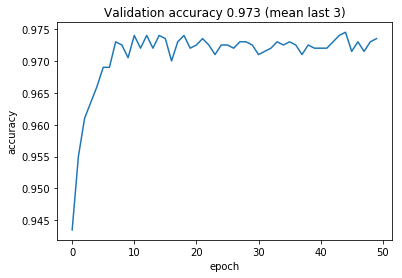

In [80]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot accuracy values
plt.plot(valid_acc_values)
plt.title('Validation accuracy {:.3f} (mean last 3)'.format(
    np.mean(valid_acc_values[-3:]) # last three values
))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

### 3 layer version 

In [81]:
# Redefine the graph
complex_graph = tf.Graph()

with complex_graph.as_default():
    # Create placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 784])
    y = tf.placeholder(dtype=tf.int32, shape=[None])

    # 1st hidden layer with 64 units
    hidden_1 = tf.layers.dense(
        X, 64, activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='hidden_1'
    )
    
    # 2nd hidden layer with 16 units
    hidden_2 = tf.layers.dense(
        hidden_1, 16, activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='hidden_2'
    )
    # Output layer
    logits = tf.layers.dense(
        hidden_2, 10, activation=None, # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='output'
    )
    # Loss fuction: mean cross-entropy
    mean_ce = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y, logits=logits))

    # Gradient descent
    lr = tf.placeholder(dtype=tf.float32)
    gd = tf.train.GradientDescentOptimizer(learning_rate=lr)

    # Minimize cross-entropy
    train_op = gd.minimize(mean_ce)

    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

In [82]:
with complex_graph.as_default():
    # Get weights/biases of the hidden layer
    with tf.variable_scope('hidden_1', reuse=True):
        W1_complex = tf.get_variable('kernel')
        b1_complex = tf.get_variable('bias')

    # Get weights/biases of the hidden layer 2
    with tf.variable_scope('hidden_2', reuse=True):
        W2_complex = tf.get_variable('kernel')
        b2_complex = tf.get_variable('bias')
        
    # Get weights/biases of the output layer
    with tf.variable_scope('output', reuse=True):
        W3_complex = tf.get_variable('kernel')
        b3_complex = tf.get_variable('bias')

In [83]:
# Validation accuracy
valid_acc_values = []

with tf.Session(graph=complex_graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Set seed
    np.random.seed(0)

    # Train several epochs
    for epoch in range(50):
        # Accuracy values (train) after each batch
        batch_acc = []

        # Get batches of data
        for X_batch, y_batch in get_batches(X_train_rescaled, y_train, 64):
            # Run training and evaluate accuracy
            _, acc_value = sess.run([train_op, accuracy], feed_dict={
                X: X_batch,
                y: y_batch,
                lr: 0.01 # Learning rate
            })

            # Save accuracy (current batch)
            batch_acc.append(acc_value)

        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={
            X: X_valid_rescaled,
            y: y_valid
        })
        valid_acc_values.append(valid_acc)

        # Print progress
        print('Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format(
            epoch+1, valid_acc, np.mean(batch_acc)
        ))

    # Weights of the hidden and output layers
    weights_hidden_1 = W1_complex.eval()
    weights_hidden_2 = W2_complex.eval()
    weights_output_complex = W3_complex.eval()

Epoch 1 - valid: 0.892 train: 0.768 (mean)
Epoch 2 - valid: 0.925 train: 0.912 (mean)
Epoch 3 - valid: 0.938 train: 0.931 (mean)
Epoch 4 - valid: 0.945 train: 0.942 (mean)
Epoch 5 - valid: 0.950 train: 0.949 (mean)
Epoch 6 - valid: 0.952 train: 0.955 (mean)
Epoch 7 - valid: 0.953 train: 0.959 (mean)
Epoch 8 - valid: 0.954 train: 0.962 (mean)
Epoch 9 - valid: 0.960 train: 0.965 (mean)
Epoch 10 - valid: 0.959 train: 0.968 (mean)
Epoch 11 - valid: 0.960 train: 0.970 (mean)
Epoch 12 - valid: 0.961 train: 0.972 (mean)
Epoch 13 - valid: 0.960 train: 0.974 (mean)
Epoch 14 - valid: 0.959 train: 0.976 (mean)
Epoch 15 - valid: 0.960 train: 0.977 (mean)
Epoch 16 - valid: 0.960 train: 0.979 (mean)
Epoch 17 - valid: 0.959 train: 0.980 (mean)
Epoch 18 - valid: 0.963 train: 0.981 (mean)
Epoch 19 - valid: 0.959 train: 0.982 (mean)
Epoch 20 - valid: 0.961 train: 0.983 (mean)
Epoch 21 - valid: 0.961 train: 0.984 (mean)
Epoch 22 - valid: 0.962 train: 0.985 (mean)
Epoch 23 - valid: 0.962 train: 0.986 (mea

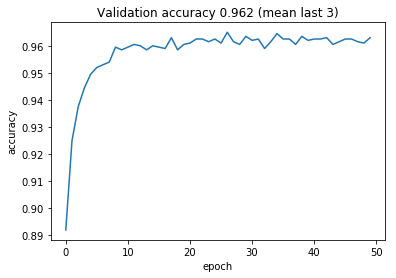

In [84]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot accuracy values
plt.plot(valid_acc_values)
plt.title('Validation accuracy {:.3f} (mean last 3)'.format(
    np.mean(valid_acc_values[-3:]) # last three values
))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Exercise - Visualize weights

> **Exercise**: Plot the weights from the first fully connected layer (the templates) with the `imshow()` function.

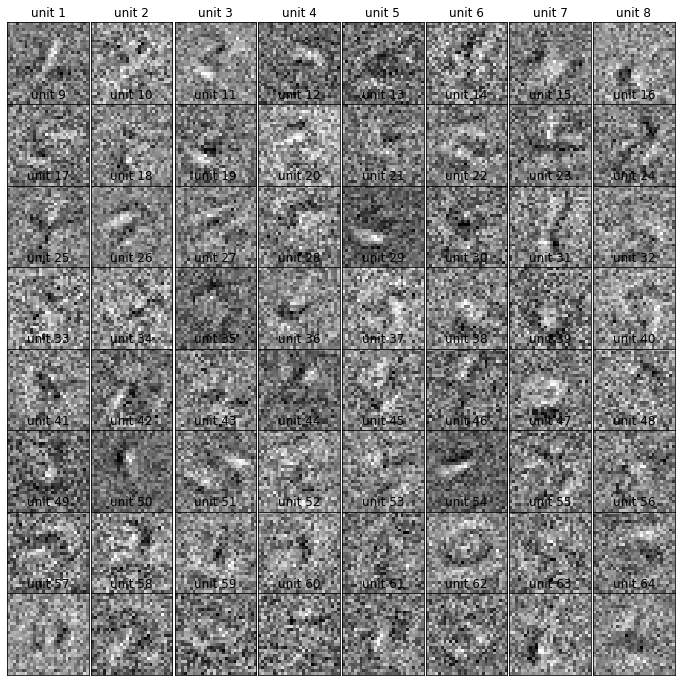

In [85]:
# Create figure with 64 subplots
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(12, 12))

# Remove gaps between suplots
plt.subplots_adjust(wspace=0, hspace=0)

# Plot the weights of the 64 hidden units
for i, axis in enumerate(axes.flatten()):
    # Get weights of i-th hidden unit
    weights = weights_hidden_1[:, i]

    # Reshape into 28 by 28 array
    weights = weights.reshape(28, 28)

    # Plot weights
    axis.set_title('unit {}'.format(i+1))
    axis.imshow(weights, cmap=plt.cm.gray_r) # Grayscale
    axis.get_xaxis().set_visible(False) # Disable x-axis
    axis.get_yaxis().set_visible(False) # Disable y-axis

plt.show()